## tutor-fastaitotorchscript
Link: https://drhb.github.io/blog/fastai/2020/03/22/Fastai-Jit.html

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [2]:
pre_sz     = 256
sz         = 224
bs         = 8
pat        = r'([^/]+)_\d+.*$'
fnames     = get_image_files(path/'images')

In [3]:
item_tfms  = [Resize(pre_sz, method='crop')]
batch_tfms = [*aug_transforms(size=sz), Normalize.from_stats(*imagenet_stats)]
dls = ImageDataLoaders.from_name_re(path, fnames, 
                                    pat, 
                                    bs=bs,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms)

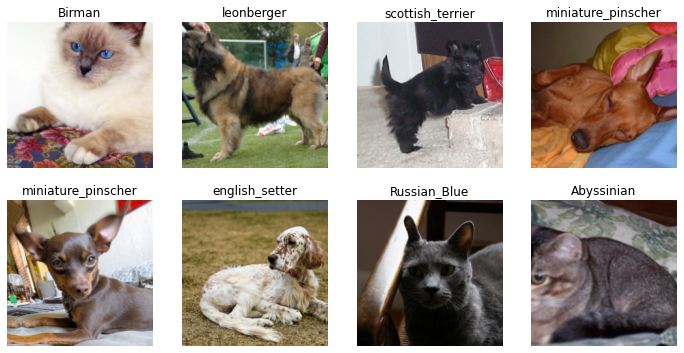

In [4]:
dls.show_batch()

In [5]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.240972,0.462588,0.845061,00:44


epoch,train_loss,valid_loss,accuracy,time
0,1.082246,0.417587,0.873478,00:51
1,0.769001,0.331476,0.890392,00:52
2,0.520369,0.276144,0.910690,00:53


In [6]:
dummy_inp = torch.randn([1,3,sz,sz]).cuda()
vocab = np.save('vocab.npy', dls.vocab)

In [7]:
torch.jit.save(torch.jit.trace(learn.model, dummy_inp), 'fa_jit.pt')

## Inference/Deploy Environment

In [1]:
import torch as torch
from torch import jit, tensor
from operator import itemgetter
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import numpy as np

from fastai.vision.all import *

In [2]:
sz     = 224
bs     = 8
path   = Path('/root/.fastai/data/oxford-iiit-pet/')
fnames = list((path/'images').iterdir())[:10]
imagenet_stats  = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [3]:
fnames

[Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_115.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_142.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_68.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_26.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_149.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_41.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_32.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_68.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_202.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_143.jpg')]

In [4]:
class PetsDS(Dataset):
    def __init__(self, fnames, stats, sz):
      self.items = fnames 
      self.stats = list(map(tensor, stats))
      self.sz = sz

    def __len__(self): 
      return len(self.items)

    def __getitem__(self, idx):
        fn = self.items[idx]
        img = Image.open(fn).resize((self.sz, self.sz)).convert('RGB')
        img = tensor(np.array(img)).float()/255
        img = self.normalize(img)
        return img.permute(2,0,1)

    def normalize(self, x):
      return (x-self.stats[0])/self.stats[1]

In [20]:
petsdl = DataLoader(PetsDS(fnames, imagenet_stats, 224), batch_size=3, num_workers=2)

In [21]:
model = torch.jit.load('fa_jit.pt')

In [22]:
vocab = np.load('vocab.npy')
vocab

array(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
       'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
       'Siamese', 'Sphynx', 'american_bulldog',
       'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer',
       'chihuahua', 'english_cocker_spaniel', 'english_setter',
       'german_shorthaired', 'great_pyrenees', 'havanese',
       'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher',
       'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed',
       'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier',
       'wheaten_terrier', 'yorkshire_terrier'], dtype='<U26')

In [23]:
def get_preds(model, dl, vocab):
  res = []
  model.eval()
  model.cuda()
  with torch.no_grad():
    for xb in petsdl:
      xb   = xb.cuda()
      pred = F.softmax(model(xb), dim=1)
      pred = torch.argmax(pred, dim=1).cpu()
      res.append(pred)
  return itemgetter(*torch.cat(res))(vocab)

In [24]:
get_preds(model, petsdl, vocab)

('Siamese',
 'leonberger',
 'Bombay',
 'japanese_chin',
 'saint_bernard',
 'Ragdoll',
 'Sphynx',
 'Ragdoll',
 'Persian',
 'scottish_terrier')